# Chest X-Ray Pneumonia Detection

**Transfer Learning with EfficientNetB0 (Training + Fine-Tuning)**

## 📌 Project Overview

In this notebook, we build a deep learning model to classify **Chest X-Ray images** into:

**NORMAL**

**PNEUMONIA**

I use **Transfer Learning** with **EfficientNetB0**, followed by **Fine-Tuning**, while applying **medical-safe data augmentation**.

# 1️⃣ Import Libraries & Configuration

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Paths & Parameters
BASE_PATH = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_STAGE_1 = 10
EPOCHS_STAGE_2 = 10

2026-02-07 20:03:21.307714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770494601.536566      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770494601.600835      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770494602.121533      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770494602.121592      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770494602.121595      17 computation_placer.cc:177] computation placer alr

# 2️⃣ Load & Prepare Dataset

In [2]:
file_paths, labels = [], []

for root, _, files in os.walk(BASE_PATH):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            label = os.path.basename(root).upper()
            if label in ['NORMAL', 'PNEUMONIA']:
                file_paths.append(os.path.join(root, file))
                labels.append(label)

# Make sure the label column is string type
labels = [str(l) for l in labels]

df = pd.DataFrame({'path': file_paths, 'label': labels}).drop_duplicates()
print(df['label'].value_counts())

label
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64


# 3️⃣ Data Generators (Medical-Safe Augmentation)

In [3]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    subset='training',
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=False
)

Found 4685 validated image filenames belonging to 2 classes.
Found 1171 validated image filenames belonging to 2 classes.


# 4️⃣ Build the Model (EfficientNetB0)

In [4]:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
)

model.summary()

2026-02-07 20:04:08.344834: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,382,884 (16.72 MB)

 Trainable params: 330,753 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

# 5️⃣ Handle Class Imbalance

In [5]:
counts = df['label'].value_counts()
class_weights = {
    train_gen.class_indices['NORMAL']: (1 / counts['NORMAL']) * (len(df) / 2.0),
    train_gen.class_indices['PNEUMONIA']: (1 / counts['PNEUMONIA']) * (len(df) / 2.0)
}

# 6️⃣ Training – Stage 1 (Top Layers)

In [6]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]

history_1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_STAGE_1,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.8688 - auc: 0.9429 - loss: 0.3244 - recall: 0.8652 - val_accuracy: 0.8984 - val_auc: 0.9448 - val_loss: 0.2408 - val_recall: 0.9688 - learning_rate: 0.0010
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.9377 - auc: 0.9841 - loss: 0.1608 - recall: 0.9331 - val_accuracy: 0.9180 - val_auc: 0.9582 - val_loss: 0.2084 - val_recall: 0.9580 - learning_rate: 0.0010
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.9444 - auc: 0.9870 - loss: 0.1376 - recall: 0.9369 - val_accuracy: 0.9129 - val_auc: 0.9483 - val_loss: 0.2664 - val_recall: 0.9720 - learning_rate: 0.0010
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.9516 - auc: 0.9904 - loss: 0.1199 - recall: 0.9473 - val_accuracy: 0.9103 - val_auc: 0.9428 - val_loss: 0.2802 - val_recall: 0.9731 - learning_rate: 0.0010
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.9555 - auc: 0.9921 - loss: 0.1154 - recal

# 7️⃣ Fine-Tuning – Stage 2

In [7]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
)

history_2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_STAGE_2,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.9118 - auc: 0.9636 - loss: 0.3098 - recall: 0.9396 - val_accuracy: 0.9112 - val_auc: 0.9514 - val_loss: 0.2482 - val_recall: 0.9397 - learning_rate: 1.0000e-05
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.9296 - auc: 0.9812 - loss: 0.1790 - recall: 0.9303 - val_accuracy: 0.9103 - val_auc: 0.9498 - val_loss: 0.2647 - val_recall: 0.9386 - learning_rate: 1.0000e-05
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.9326 - auc: 0.9823 - loss: 0.1713 - recall: 0.9319 - val_accuracy: 0.9137 - val_auc: 0.9498 - val_loss: 0.2633 - val_recall: 0.9429 - learning_rate: 1.0000e-05
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.9406 - auc: 0.9859 - loss: 0.1478 - recall: 0.9313 - val_accuracy: 0.9163 - val_auc: 0.9501 - val_loss: 0.2623 - val_recall: 0.9462 - learning_rate: 2.0000e-06
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.9388 - auc: 0.9866 - loss

# 8️⃣ Plot Training Results

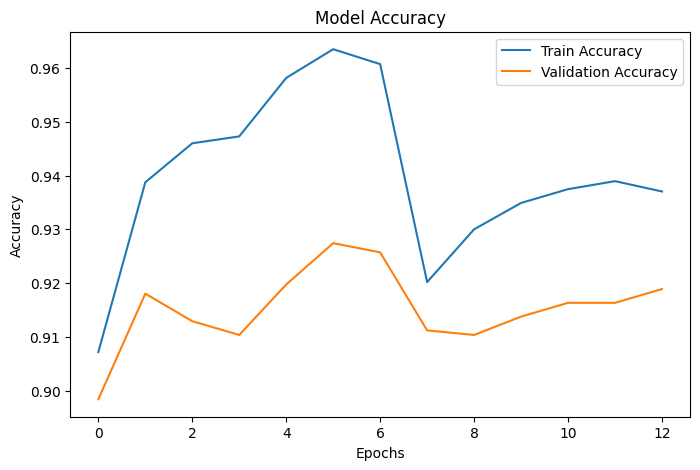

In [8]:
plt.figure(figsize=(8,5))
plt.plot(history_1.history['accuracy'] + history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'] + history_2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()